/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


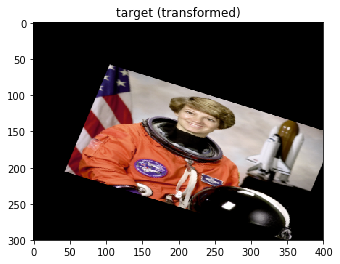

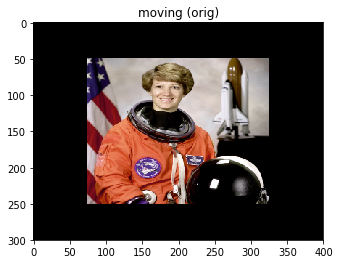

In [34]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

from scipy import interpolate
from scipy import ndimage as ndi

import skimage.data
import skimage.filters
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# import register
import utils

im = skimage.data.astronaut()
ORIG_SIZE = (200, 250)
im = np.uint8(255 * skimage.transform.resize(im, ORIG_SIZE))

PADDED_IM_SIZE = (300, 400) 

# try warping 

true_scale = (1.3, .8)
true_rotation = .3
true_shear = .1
true_translation = (30, 30)
# true_translation = (50, -30)


aff_tfm = skimage.transform.AffineTransform(
    scale=true_scale,
    rotation=true_rotation,
    shear=true_shear,
    translation=true_translation)

im_fixed = utils.apply_matrix_tform(
    utils.resize_image(im, PADDED_IM_SIZE), aff_tfm)

im_moving = utils.resize_image(im, PADDED_IM_SIZE)

im_fixed_unpadded = utils.apply_matrix_tform(
    utils.resize_image(im, ORIG_SIZE), aff_tfm)


plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.show()

(150, 189)


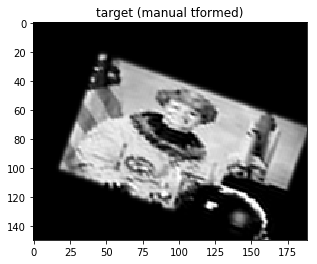

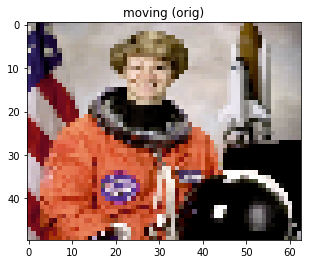

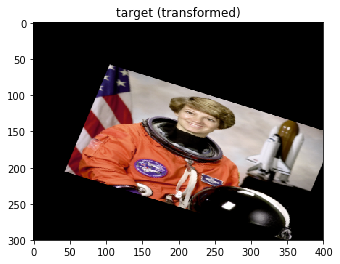

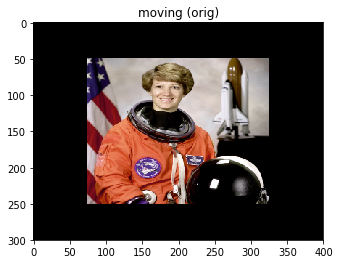

In [38]:
""" RBF
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html
"""

SAMP_SPACE = 4
# just like in MATLAB, this seems flipped?
# for ranges and grids: x is the columns and y is rows
x_range = np.arange(0, im.shape[1] / SAMP_SPACE)
y_range = np.arange(0, im.shape[0] / SAMP_SPACE)
xx, yy = np.meshgrid(x_range, y_range)

im_moving_sampled = im[::SAMP_SPACE, ::SAMP_SPACE]

xin, yin = xx.flatten(), yy.flatten()

# double checking flattening/reshaping
xx_in_out = np.reshape(xin, xx.shape)
yy_in_out = np.reshape(yin, xx.shape)

assert np.allclose(xx, xx_in_out)
assert np.allclose(yy, yy_in_out)

# list coordinates in input image
xy_in = np.array([xin, yin, np.ones(len(xin))])
shift = np.array([xx.shape[0], xx.shape[1], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))
xy_in = xy_in - shift

# apply transform
tform = aff_tfm.params
tform[0, 2] = tform[0, 2] / SAMP_SPACE
tform[1, 2] = tform[1, 2] / SAMP_SPACE
xy_out = np.dot(tform, xy_in).T
xy_out = xy_out + shift.T

rbf_interp = interpolate.Rbf(
    xy_out[:, 0], xy_out[:, 1], 
    im_moving_sampled[:, :, 0].flatten() / 255.0, 
    function='gaussian', smooth=0.001, epsilon=1)

# # this has to be on a regular grid
x_range_pad = np.linspace(
    -20, im.shape[1] / SAMP_SPACE + 20, xx.shape[1] * 3)
y_range_pad = np.linspace(
    -10, im.shape[0] / SAMP_SPACE + 10, xx.shape[0] * 3)

xx, yy = np.meshgrid(x_range_pad, y_range_pad)
im_new = rbf_interp(xx.flatten(), yy.flatten())
im_new = im_new.reshape(xx.shape)

# im_new = im_new / im_new.max()
im_new = np.clip(im_new, 0, 1)
im_new = np.uint8(255 * im_new)

print(im_new.shape)

plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving_sampled)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()


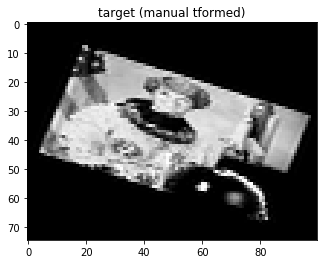

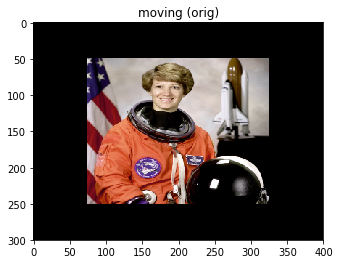

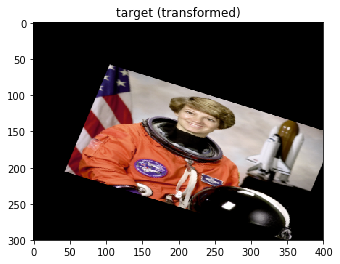

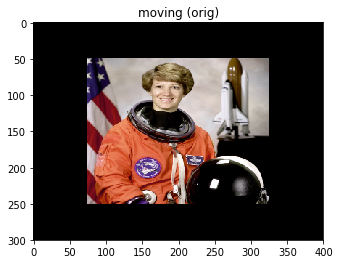

In [42]:
""" warp directly
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp
"""

SAMP_SPACE = 4
# just like in MATLAB, this seems flipped?
# for ranges and grids: x is the columns and y is rows
x_range = np.arange(0, im_moving.shape[1] / SAMP_SPACE)
y_range = np.arange(0, im_moving.shape[0] / SAMP_SPACE)
xx, yy = np.meshgrid(x_range, y_range)

im_moving_sampled = im_moving[::SAMP_SPACE, ::SAMP_SPACE]

xin, yin = xx.flatten(), yy.flatten()

# double checking flattening/reshaping
xx_in_out = np.reshape(xin, xx.shape)
yy_in_out = np.reshape(yin, xx.shape)

assert np.allclose(xx, xx_in_out)
assert np.allclose(yy, yy_in_out)

# list coordinates in input image
shift = np.array([xx.shape[1], xx.shape[0], 0]).T / 2
shift = np.reshape(shift, (len(shift), 1))


def trans_xy(xy):
    xy_in = np.array([xy[:, 0], xy[:, 1], np.ones(len(xy))])
    xy_in = xy_in - shift
    
    # apply transform
    tform_inv = np.linalg.inv(aff_tfm.params)
    tform_inv[0, 2] = tform_inv[0, 2] / SAMP_SPACE
    tform_inv[1, 2] = tform_inv[1, 2] / SAMP_SPACE
    
    xy_out = np.dot(tform_inv, xy_in).T
    xy_out = xy_out + shift.T
    
    xy_out =  np.array([xy_out[:, 0], xy_out[:, 1]])
    return xy_out.T


coord = skimage.transform.warp_coords(trans_xy, xx.shape)

im_new = skimage.transform.warp(
    im_moving_sampled[:,:,0] / 255.0, coord,
    order=3, preserve_range=True, mode='constant',
    clip=True
)

# im_new = im_new / im_new.max()
im_new = np.clip(im_new, 0, 1)
im_new = np.uint8(255 * im_new)

plt.figure(1)
plt.title('target (manual tformed)')
plt.imshow(im_new, cmap='gray')
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.figure(3)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(4)
plt.title('moving (orig)')
plt.imshow(im_moving)

plt.show()


In [44]:
coord


array([[[ 10.66795543,  10.29670044,   9.92544545, ..., -25.3437783 ,
         -25.71503329, -26.08628828],
        [ 11.86812187,  11.49686688,  11.1256119 , ..., -24.14361186,
         -24.51486684, -24.88612183],
        [ 13.06828831,  12.69703333,  12.32577834, ..., -22.94344541,
         -23.3147004 , -23.68595539],
        ...,
        [ 97.07993944,  96.70868445,  96.33742946, ...,  61.06820571,
          60.69695072,  60.32569574],
        [ 98.28010588,  97.90885089,  97.53759591, ...,  62.26837215,
          61.89711717,  61.52586218],
        [ 99.48027233,  99.10901734,  98.73776235, ...,  63.4685386 ,
          63.09728361,  62.72602863]],

       [[  2.63218536,   3.34425118,   4.056317  , ...,  71.70256991,
          72.41463573,  73.12670155],
        [  2.93324196,   3.64530778,   4.3573736 , ...,  72.00362651,
          72.71569233,  73.42775815],
        [  3.23429856,   3.94636438,   4.6584302 , ...,  72.30468311,
          73.01674893,  73.72881475],
        ...,


In [89]:
def trans_xy(xy):
    xy_in = np.array([xy[:, 0], xy[:,1], np.ones(len(xy))])
    xy_in = xy_in - shift

    # apply transform
    tform = aff_tfm.params
    xy_out = np.dot(tform, xy_in).T
    xy_out = xy_out + shift.T
    
    return np.array([xy_out[:, 0], xy_out[:, 1]])

coord = skimage.transform.warp_coords(trans_xy, xx.shape)


(2, 50, 63)